# Real data

In [1]:
import pickle
import re

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

from utils import extract_data, basic_sep, arrays_to_complex
from qubit_measurement_analysis.data import SingleShot, ShotCollection

from qubit_measurement_analysis.classification.temporal_post_processor import TPP
from qubit_measurement_analysis.classification import GaussianMixtureModels
from qubit_measurement_analysis.classification.metrics import Metrics as M 

import scienceplots

plt.style.use(["science", "no-latex"])
# plt.style.use("default")


fontsize = 12
plt.rcParams.update({"font.size": fontsize, "lines.linewidth": 1.5})

In [2]:
qubit = 1-1

data_path1 = Path(
    r"C:\Users\nokol\OneDrive\Deep Learning\state_discriminator\pkl_data\4_qubits\4Q_readout\singleshots_sep_Q1-Q2-Q3-Q4"
)
data_path1 = Path(r"/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4")

# Define the regular expression pattern
pattern1 = re.compile(r"(0000|1111)_Q1\.pkl$")
pattern16 = re.compile(r"_Q1\.pkl$")

# retrieve paths of selected files
INPUT_FILES16 = sorted([file for file in data_path1.glob("*.pkl") if pattern16.search(file.name)])

INPUT_FILES16

[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0000_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0001_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0010_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0011_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0100_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0101_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0110_Q1.pkl'),
 PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots

In [3]:
from typing import Iterable
def collection_from_files(input_files, trc_st=0, trc_en=1000, samples_slice=slice(5000), qubit_idx=None): 
    collection = ShotCollection()
    for file in input_files:
        with open(file, "rb") as f:
            data = pickle.load(f)
        keys, values = extract_data(file)
        # print(f"qubits: {keys}\tprep state: {values}")
        if qubit_idx:
            keys = keys[qubit_idx:qubit_idx+1]
            values = values[qubit_idx:qubit_idx+1]
            
        qubits_classes = {key: value for key, value in zip(keys, values)}
        meas_time = data[3]
        if ~isinstance(data[2], Iterable):
            freqs = {keys[0]: data[2]}
        else: 
            freqs = {key: value for key, value in zip(keys, data[2])}
        in_phase_state = data[0]
        quadrature_state = data[1]

        in_phase_state, quadrature_state, meas_time = basic_sep(
        in_phase_state, quadrature_state, meas_time, trc_st, trc_en
        )
        values = arrays_to_complex(
            in_phase_state[samples_slice], quadrature_state[samples_slice]
        )
        
        # print(f"values Mb: {values.nbytes * 1e-6}, meas_time Mb: {meas_time.nbytes * 1e-6}")

        collection.extend(
            [SingleShot(value=value, qubits_classes=qubits_classes) for value in values]
        )
    return collection, freqs, meas_time

        

In [4]:
TRC_ST = 200
TRC_EN = 1192

LAMBDA = 700

## State 0

In [5]:
current_files = INPUT_FILES16[:8]

current_states = [str(string)[-11:-7] for string in current_files]
current_states

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111']

In [6]:
import fastcluster as fc

for i in range(0, len(current_files), 2):
    curr = current_files[i : i + 2]
    curr_states = [str(string)[-11:-7] for string in curr]
    print(curr)
    collection, freqs, meas_time = collection_from_files(
        curr, trc_st=TRC_ST, trc_en=TRC_EN, samples_slice=slice(10000)
    )

    collection = (
        collection.mean_centring_all()
        .demodulate_all(freqs, meas_time, "clockwise")
        .compute()
    )
    print(collection.shape)

    z_naming = f"Z_{'_'.join(curr_states)}_lamb_{LAMBDA}.npy"
    print(z_naming)

    collection_smooth = collection.whittaker_eilers_smoother_all(LAMBDA, 2).compute()
    collection_smooth.to("cuda")
    distance_matrix = collection_smooth.sspd_to(collection_smooth, method="self_cross_product")

    Z = fc.linkage(distance_matrix[0], method="complete")

    collection_smooth.to("cpu")
    collection.to("cpu")

    np.save(z_naming, np.array(Z))
    

[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0000_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0001_Q1.pkl')]
(20000, 1, 992)
Z_0000_0001_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0010_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0011_Q1.pkl')]
(20000, 1, 992)
Z_0010_0011_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0100_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_0101_Q1.pkl')]
(20000, 1, 992)
Z_0100_0101_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q

## State 1

In [7]:
current_files = INPUT_FILES16[8:]

current_states = [str(string)[-11:-7] for string in current_files]
current_files, current_states

([PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1000_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1001_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1010_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1011_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1100_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1101_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1110_Q1.pkl'),
  PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/sin

In [8]:
import fastcluster as fc

for i in range(0, len(current_files), 2):
    curr = current_files[i : i + 2]
    curr_states = [str(string)[-11:-7] for string in curr]
    print(curr)
    collection, freqs, meas_time = collection_from_files(
        curr, trc_st=TRC_ST, trc_en=TRC_EN, samples_slice=slice(10000)
    )

    collection = (
        collection.mean_centring_all()
        .demodulate_all(freqs, meas_time, "clockwise")
        .compute()
    )
    print(collection.shape)

    z_naming = f"Z_{'_'.join(curr_states)}_lamb_{LAMBDA}.npy"
    print(z_naming)

    collection_smooth = collection.whittaker_eilers_smoother_all(LAMBDA, 2).compute()
    collection_smooth.to("cuda")
    distance_matrix = collection_smooth.sspd_to(collection_smooth, method="self_cross_product")

    Z = fc.linkage(distance_matrix[0], method="complete")

    collection_smooth.to("cpu")
    collection.to("cpu")

    np.save(z_naming, np.array(Z))

[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1000_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1001_Q1.pkl')]
(20000, 1, 992)
Z_1000_1001_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1010_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1011_Q1.pkl')]
(20000, 1, 992)
Z_1010_1011_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1100_Q1.pkl'), PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q2-Q3-Q4_1101_Q1.pkl')]
(20000, 1, 992)
Z_1100_1101_lamb_700.npy
[PosixPath('/home/kolya/github/data/snowdrop4Q/4Q_readout/singleshots_sep_Q1-Q2-Q3-Q4/singleshots_sep_Q1-Q

# Synthetic data

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from qubit_measurement_analysis.data import SingleShot, ShotCollection

from qubit_measurement_analysis.classification.metrics import Metrics as M 

from data_generator import generate_relaxation_data

import scienceplots

plt.style.use(["science", "no-latex"])
# plt.style.use("default")

SEED = 42
qubit = 0

fontsize = 12
plt.rcParams.update({"font.size": fontsize, "lines.linewidth": 1.5})

In [3]:
def plot_classes_detail(clusterized_col, col=None, lamb=None, class_=None, suptitle=None):

    if class_ is None:
        class_ = clusterized_col.unique_classes_by_qubit(qubit+1)

    if lamb is not None:
        clusterized_col = clusterized_col.to("cpu", True).whittaker_eilers_smoother_all(lamb, 2).compute()

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

    for unique_qubits_classes in clusterized_col.unique_qubits_classes:
        if unique_qubits_classes[qubit+1] in class_:
            temp_col = clusterized_col.filter_by_qubits_classes(unique_qubits_classes)
            temp_col_val = temp_col.mean(0).value.squeeze()
            label_ = f"{unique_qubits_classes[qubit+1]}: len: {len(temp_col)}"

            ax[0].plot(meas_time, temp_col_val.real, label=label_)
            ax[0].set_title("in-phase")

            ax[1].plot(meas_time, temp_col_val.imag)
            ax[1].set_title("quadrature")

            temp_col.mean().compute().scatter(ax[2])
    
    if col is not None:
        if lamb is not None:
            col = col.to("cpu", True).whittaker_eilers_smoother_all(lamb, 2).compute()
        ref_0 = col.filter_by_pattern("0").mean(0).value.squeeze()
        ref_1 = col.filter_by_pattern("1").mean(0).value.squeeze()
        ax[0].plot(meas_time, ref_0.real, color="grey", label="0 ref")
        ax[0].plot(meas_time, ref_1.real, color="black", label="1 ref")

        ax[1].plot(meas_time, ref_0.imag, color="grey", label="0 ref")
        ax[1].plot(meas_time, ref_1.imag, color="black", label="1 ref")

    
    ax[0].legend()

    ax[2].set_title("Boxcar Filter")
    ax[2].legend(title="class  qubit")

    if suptitle is not None:
        plt.suptitle(suptitle)

    plt.tight_layout()

In [4]:
batch = 20000
noise_amp = 1300
meas_time = np.arange(0, 1.984e-6, 2e-9)

data, labels = generate_relaxation_data(
        batch_size=batch,
        meas_time=meas_time,
        I_amp_1=-200,
        Q_amp_1=400,
        I_amp_0=-250,
        Q_amp_0=200,
        relax_time_transition=1e-9,
        T1=50e-6,  # 20 microseconds T1
        gauss_noise_amp=noise_amp,
        qubit=qubit+1,
        seed=SEED
    )

data0, labels0 = generate_relaxation_data(
        batch_size=int(batch*0.03),
        meas_time=meas_time,
        I_amp_0=-250,
        Q_amp_0=200,
        gauss_noise_amp=noise_amp,
        qubit=qubit+1,
        seed=SEED
    )

In [5]:
synthetic_collection: ShotCollection = ShotCollection(_use_cython=True)
synthetic_collection.extend(
            [SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True) for value, qubits_classes in zip(data, labels)]
        )
synthetic_collection.extend(
            [SingleShot(value=value, qubits_classes=qubits_classes, _is_demodulated=True) for value, qubits_classes in zip(data0, labels0)]
        )

{'2': 752, '0': 600, '1': 19248}


<Axes: >

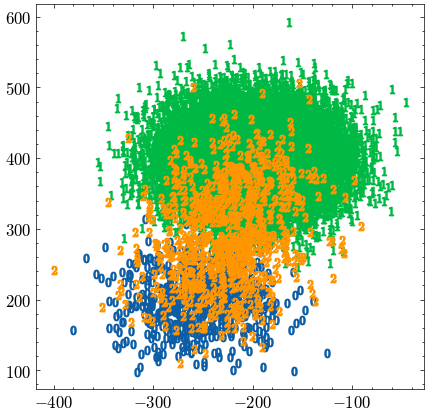

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
print(synthetic_collection.counts)
synthetic_collection.mean().compute().scatter(ax)

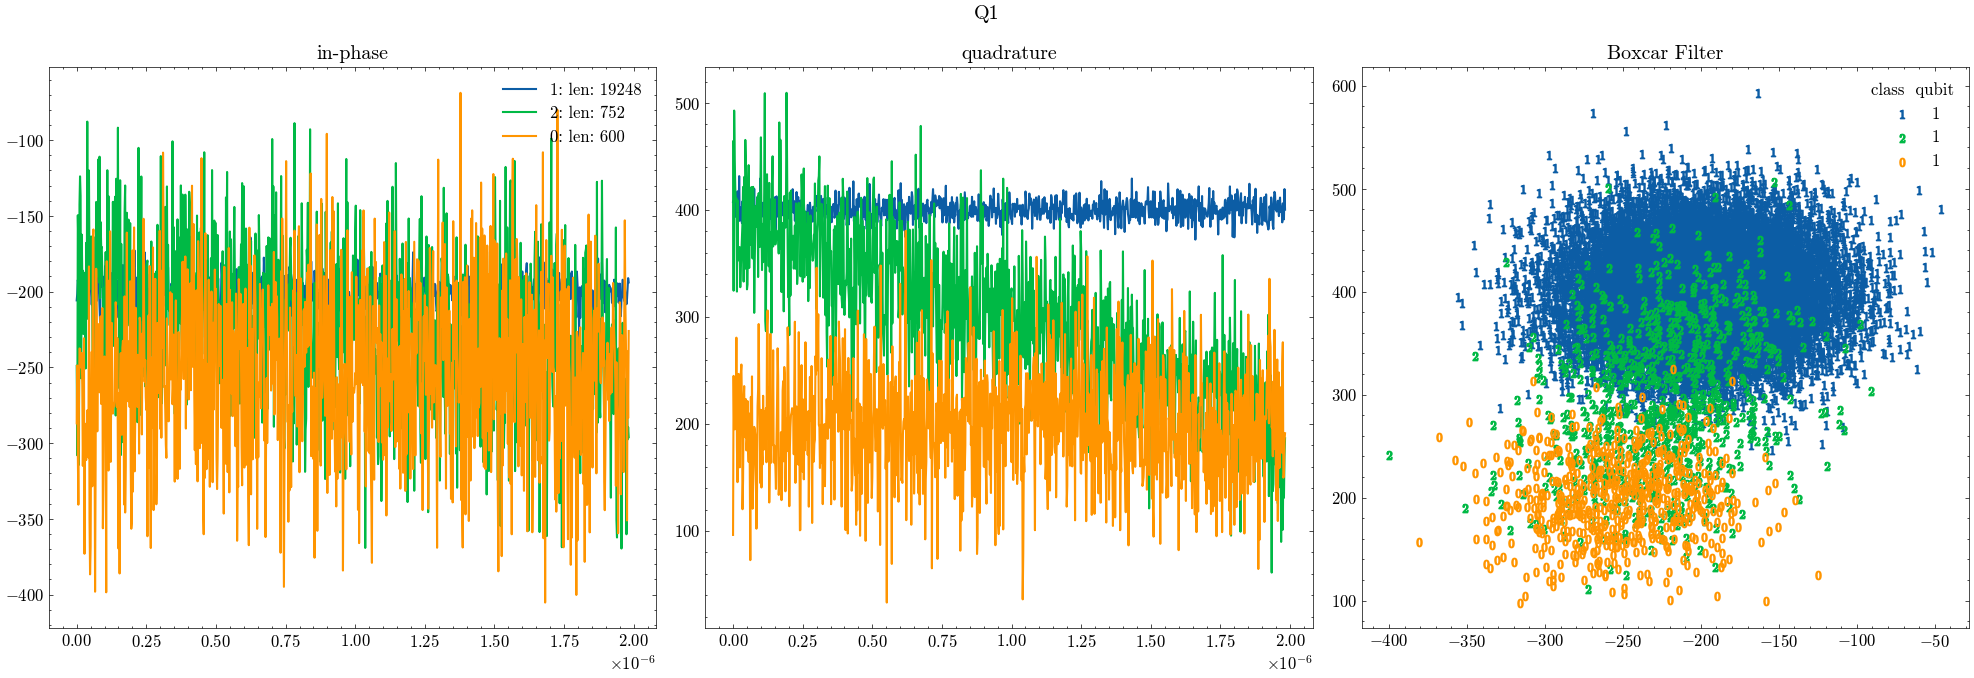

In [7]:
lamb = 1e4
plot_classes_detail(synthetic_collection, suptitle=f"Q{qubit+1}")

## Cluster

In [8]:
data_dir = Path("experiments_data")
data_dir.mkdir(parents=True, exist_ok=True)

In [9]:
import scipy.cluster.hierarchy as sch

def get_clusterized_col(col, Z, num_classes):
    labels = sch.fcluster(Z, num_classes, criterion="maxclust")
    singleshots = [
        SingleShot(
            shot.value, {qubit + 1: state}, shot.is_demodulated, shot.device, shot.id
        )
        for shot, state in zip(col.singleshots, labels)
    ]
    return ShotCollection(singleshots, device=col.device, _use_cython=True)

### Var labmdas, const batch

In [10]:
lambdas = [10, 100, 1000, 10000]
batch = synthetic_collection.shape[0]
batch

20600

In [11]:
import fastcluster as fc

for lamb in lambdas:
    z_naming = f"Z_batch_{batch}_lamb_{lamb}.npy"
    print(z_naming)

    collection_smooth = synthetic_collection.whittaker_eilers_smoother_all(lamb, 2).compute()
    collection_smooth.to("cuda")
    distance_matrix = collection_smooth.sspd_to(collection_smooth, method="self_cross_product")

    Z = fc.linkage(distance_matrix[0], method="complete")

    collection_smooth.to("cpu")
    synthetic_collection.to("cpu")

    np.save(data_dir / z_naming, np.array(Z))

Z_batch_20600_lamb_10.npy
Z_batch_20600_lamb_100.npy
Z_batch_20600_lamb_1000.npy
Z_batch_20600_lamb_10000.npy


#### Check result

In [12]:
def load_Z(batch, lamb):
    z_naming = f"Z_batch_{batch}_lamb_{lamb}.npy"
    Z = np.load(data_dir / z_naming)
    return Z

In [13]:
Z_10 = load_Z(batch, 10)
Z_100 = load_Z(batch, 100)
Z_1000 = load_Z(batch, 1000)
Z_10000 = load_Z(batch, 10000)

In [55]:
col_1000.counts

{'2': 19714, '1': 886}

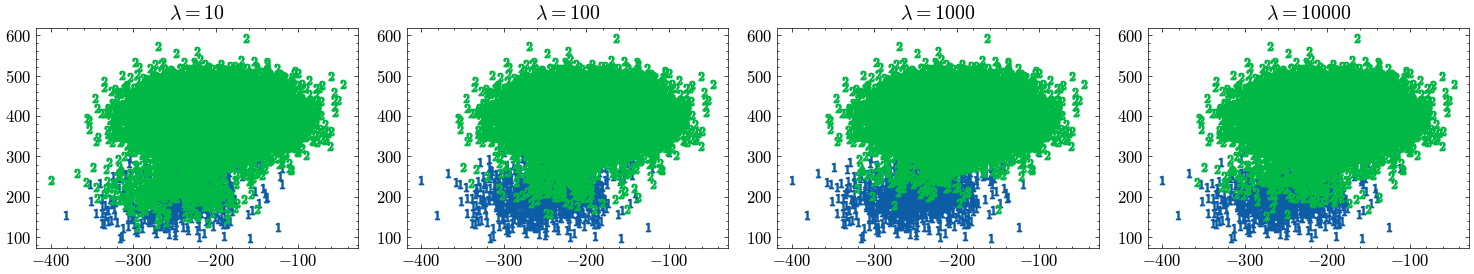

In [54]:
# reassign = {1:0, 2:2, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:1}
col_10 = get_clusterized_col(synthetic_collection, Z_10, 2)
# col_10.update_all_qubits_classes({1:reassign})

# reassign = {1:2,2:0, 3:2, 4:2, 5:1, 6:1, 7:2, 8:1, 9:1, 10:1, 11:1, 12:1, 13:1, 14:1, 15:1}
col_100 = get_clusterized_col(synthetic_collection, Z_100, 2)
# col_100.update_all_qubits_classes({1:reassign})

# reassign = {1:0, 2:0, 3:0, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:2, 12:1, 13:1, 14:1, 15:1}
col_1000 = get_clusterized_col(synthetic_collection, Z_1000, 2)
# col_1000.update_all_qubits_classes({1:reassign})

# reassign = {1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1, 9:1, 10:1, 11:1, 12:1,13:2,14:1,15:1}
col_10000 = get_clusterized_col(synthetic_collection, Z_10000, 2)
# col_10000.update_all_qubits_classes({1:reassign})


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))

col_10.mean().compute().scatter(ax[0])
col_100.mean().compute().scatter(ax[1])
col_1000.mean().compute().scatter(ax[2])
col_10000.mean().compute().scatter(ax[3])
ax[0].set_title("$\lambda = 10$")
ax[1].set_title("$\lambda = 100$")
ax[2].set_title("$\lambda = 1000$")
ax[3].set_title("$\lambda = 10000$")
plt.tight_layout()

In [40]:
# plot_classes_detail(col_10000, suptitle=f"Q{qubit+1}", lamb=1000, class_=[11,12,13,14,15])

#### Metrics

In [41]:
def calculate_accuracy(confusion_matrix):
    """
    Calculate the accuracy from a confusion matrix.
    """
    return np.trace(confusion_matrix) / np.sum(confusion_matrix)

def calculate_precision(confusion_matrix):
    """
    Calculate precision for each class from a confusion matrix.
    Handles cases where a class has no predictions (division by zero).
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
        precision[np.isnan(precision)] = 0  # Set precision to 0 for missing predicted classes
    return precision

def calculate_recall(confusion_matrix):
    """
    Calculate recall for each class from a confusion matrix.
    Handles cases where a class has no true instances (division by zero).
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
        recall[np.isnan(recall)] = 0  # Set recall to 0 for missing true instances
    return recall

In [42]:
conf_matrics = [M.get_conf_matrix(synthetic_collection, pred) for pred in [col_10, col_100, col_1000, col_10000]]

In [43]:
accs = np.array([calculate_accuracy(cnf_mtrx) for cnf_mtrx in conf_matrics])
accs

array([0.93781553, 0.93140777, 0.93762136, 0.95796117])

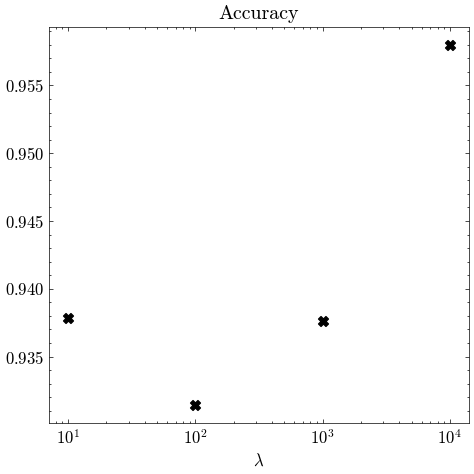

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(lambdas, accs, color="black", marker="X", s=50)
ax.set_title("Accuracy")
ax.set_xscale('log')
ax.set_xlabel("$\lambda$")
plt.tight_layout()

In [45]:
precs = np.array([calculate_precision(cnf_mtrx) for cnf_mtrx in conf_matrics])
precs

array([[0.7254902 , 0.96108497, 0.24315068],
       [0.76793249, 0.97342331, 0.2295082 ],
       [0.60045147, 0.97597206, 0.10984848],
       [0.70444763, 0.97262709, 0.42924528]])

In [46]:
recs = np.array([calculate_recall(cnf_mtrx) for cnf_mtrx in conf_matrics])
recs

array([[0.30833333, 0.98669992, 0.18882979],
       [0.30333333, 0.97428304, 0.33510638],
       [0.88666667, 0.97282835, 0.07712766],
       [0.81833333, 0.99501247, 0.12101064]])

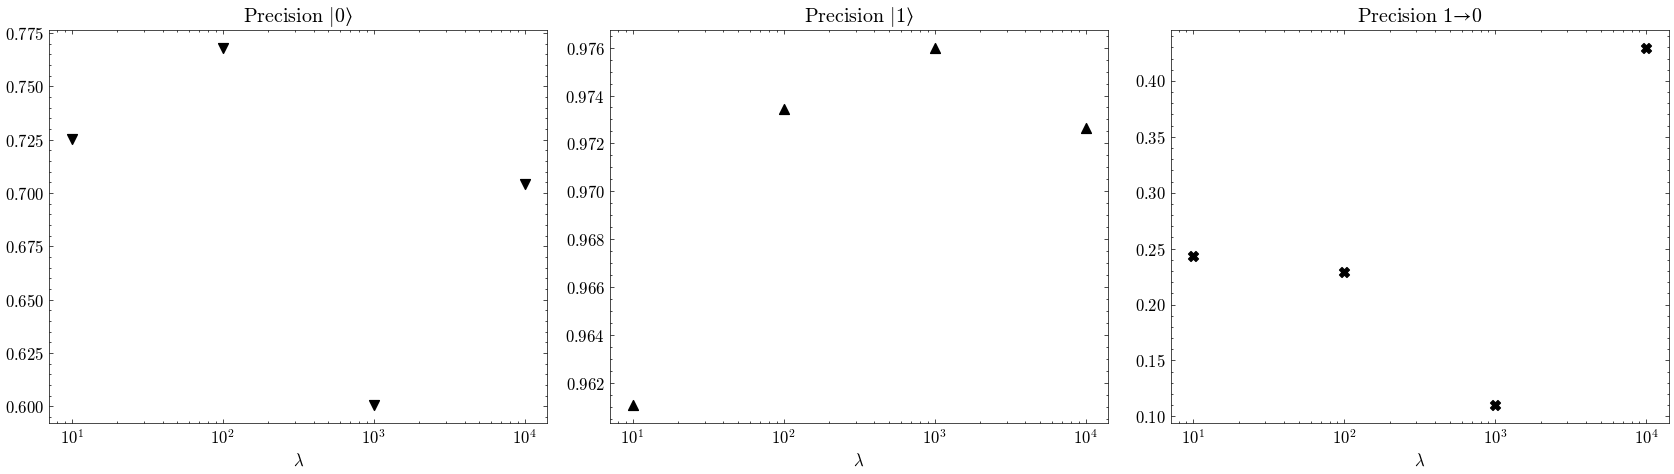

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(17, 5))
ax[0].scatter(lambdas, precs[:,0], color="black", marker="v", s=50)
ax[0].set_title("Precision $|0⟩$")
ax[0].set_xscale('log')
ax[0].set_xlabel("$\lambda$")

ax[1].scatter(lambdas, precs[:,1], color="black", marker="^", s=50)
ax[1].set_title("Precision $|1⟩$")
ax[1].set_xscale('log')
ax[1].set_xlabel("$\lambda$")


ax[2].scatter(lambdas, precs[:,2], color="black", marker="X", s=50)
ax[2].set_title("Precision $1→0$")
ax[2].set_xscale('log')
ax[2].set_xlabel("$\lambda$")
plt.tight_layout()

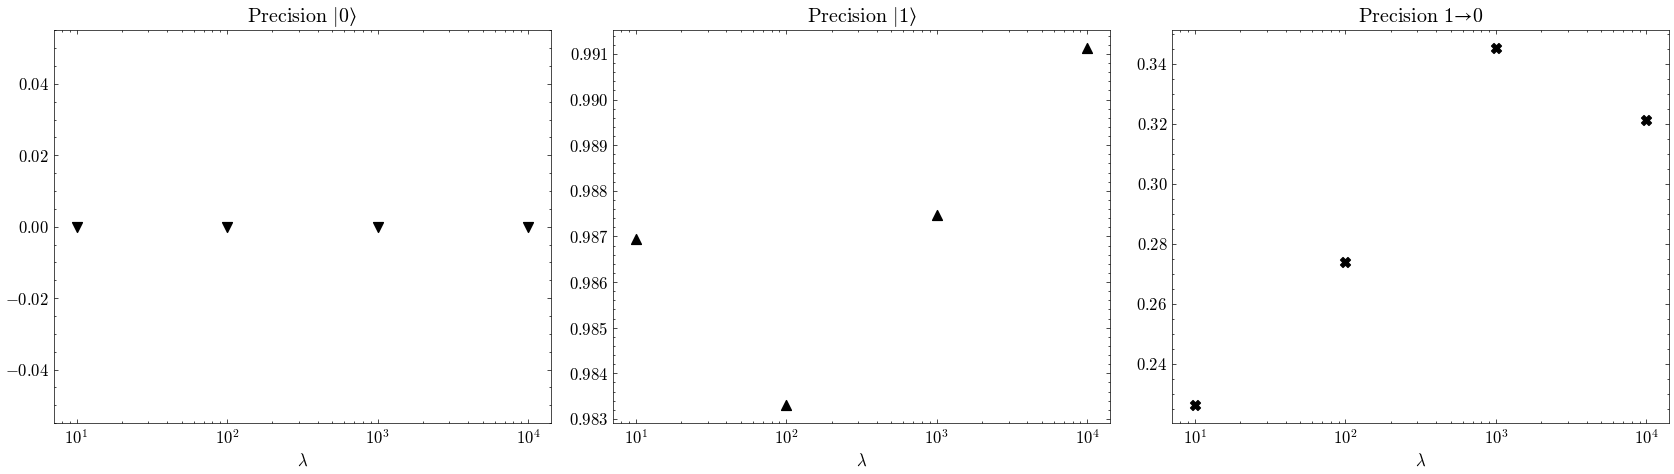

In [95]:
fig, ax = plt.subplots(ncols=3, figsize=(17, 5))
ax[0].scatter(lambdas, recs[:,0], color="black", marker="v", s=50)
ax[0].set_title("Precision $|0⟩$")
ax[0].set_xscale('log')
ax[0].set_xlabel("$\lambda$")

ax[1].scatter(lambdas, recs[:,1], color="black", marker="^", s=50)
ax[1].set_title("Precision $|1⟩$")
ax[1].set_xscale('log')
ax[1].set_xlabel("$\lambda$")


ax[2].scatter(lambdas, recs[:,2], color="black", marker="X", s=50)
ax[2].set_title("Precision $1→0$")
ax[2].set_xscale('log')
ax[2].set_xlabel("$\lambda$")
plt.tight_layout()